In [50]:
import os
import tifffile
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Data Visualization

In [18]:
PALLETE = [
        [0, 204, 242],
        [230, 0, 77],
        [204, 204, 204],
        [100, 180, 50],
        [180, 230, 77],
        [255, 230, 166],
        [150, 77, 255]
        ]

In [3]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min) / ((band_max - band_min)))

In [4]:
def brighten(band):
    alpha = 0.13
    beta = 0
    return np.clip(alpha * band + beta, 0, 255)

In [10]:
def convert(im_path):
    with rasterio.open(im_path) as fin:
        red = fin.read(3)
        green = fin.read(2)
        blue = fin.read(1)

    red_b = brighten(red)
    blue_b = brighten(blue)
    green_b = brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    return np.dstack((blue_b, green_b, red_b)), np.dstack((red_bn, green_bn, blue_bn))

In [29]:
def plot_data(image_path, mask_path):
    plt.figure(figsize=(12, 12))
    pal = [value for color in PALLETE for value in color]
    
    plt.subplot(1, 2, 1)
    _, img = convert(image_path)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    mask = tifffile.imread(mask_path)
    mask = Image.fromarray(mask).convert('P')
    mask.putpalette(pal)
    plt.imshow(mask)
    plt.show();

In [30]:
image_path = 'valid/images/small_01_01.tif'
mask_path = 'valid/masks/small_01_01.tif'

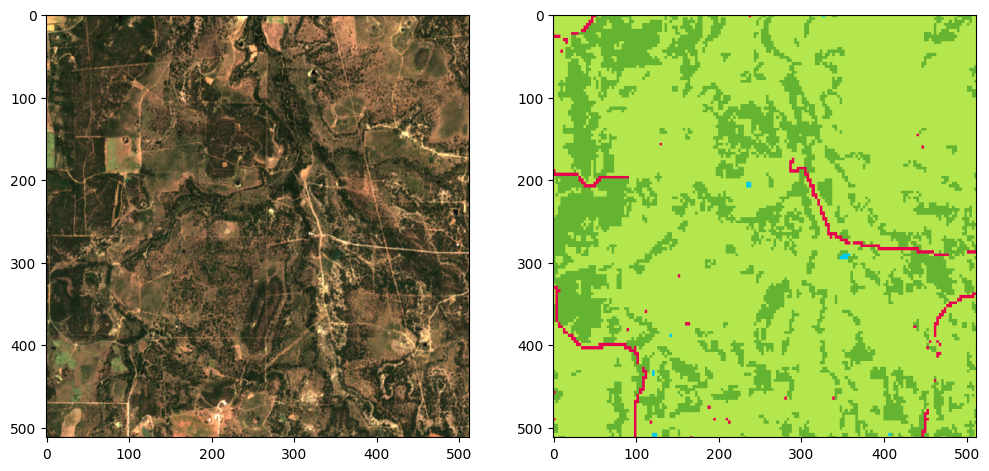

In [31]:
plot_data(image_path, mask_path)

# Reading Data and creating Dataloader example in Pytorch

In [35]:
def image_padding(image, target_size=512):
    """
    Pad an image to a target size using reflection padding.
    """
    height, width = image.shape[1:3]
    pad_height = max(0, target_size - height)
    pad_width = max(0, target_size - width)
    padded_image = np.pad(image, ((0, 0), (0, pad_height),
                                  (0, pad_width)), mode='reflect')
    return padded_image


def mask_padding(mask, target_size=512):
    """
    Pad a mask to a target size using reflection padding.
    """
    height, width = mask.shape
    pad_height = max(0, target_size - height)
    pad_width = max(0, target_size - width)
    padded_mask = np.pad(mask, ((0, pad_height), (0, pad_width)),
                         mode='reflect')
    return padded_mask

In [36]:
def get_data_list(img_path):
    """
    Retrieves a list of file names from the given directory.
    """
    name = []
    for _, _, filenames in os.walk(img_path): # given a directory iterates over the files
        for filename in filenames:
            f = filename.split('.')[0]
            name.append(f)

    df =  pd.DataFrame({'id': name}, index = np.arange(0, len(name))
                       ).sort_values('id').reset_index(drop=True)
    df = df['id'].values

    return np.delete(df, 0)

In [37]:
class LandcoverDataset(Dataset):
    def __init__(self, img_path, mask_path, file_names):
        self.img_path = img_path
        self.mask_path = mask_path
        self.file_names = file_names

    def __len__(self):
            return len(self.file_names)

    def __getitem__(self, idx):
        image = tifffile.imread(self.img_path + self.file_names[idx] + '.tif')
        image = np.moveaxis(image, [0, 1, 2], [1, 2, 0])
        image = image_padding(image).astype(np.float32)

        mask = tifffile.imread(self.mask_path + self.file_names[idx] + '.tif')
        mask = mask_padding(mask)

        return image, mask

In [45]:
data_list = get_data_list('valid/images/')

In [46]:
data_list[:2]

array(['small_01_02', 'small_01_03'], dtype=object)

In [48]:
ds = LandcoverDataset(
    img_path='valid/images/', 
    mask_path='valid/masks/', 
    file_names=data_list
)

In [51]:
dl = DataLoader(ds)

In [52]:
for item in dl:
    image, mask = item
    print(image.shape, mask.shape)
    break

torch.Size([1, 10, 512, 512]) torch.Size([1, 512, 512])


**Here we have one Sentinel-2A image with 10 channels:**

1. B02
2. B03
3. B04
4. B05
5. B06
6. B07
7. B08
8. B8A
9. B11
10. B12

**And segmentation mask with values from 0 to 4:**

0. open water
1. settlements
2. bair soil
3. forest
4. grassland